# Intro

We are going to use 2023/24 English Premier League Data to attempt building a predictive model, via Multiple Regression. We will use R2 and Cross Validated R2 values to select the most appropriate regressors, before testing the model on 2022/23 data and analyzing its effectiveness.

In [1]:
import matplotlib
import matplotlib.pyplot as plt 
import scipy.optimize as so
import seaborn as sns
import pandas as pd 
import numpy as np

In [2]:
df1=pd.read_csv("C:/Users/dakae/Downloads/archive (1)/23_24_premier_league_0408_general.csv")
df2=pd.read_csv("C:/Users/dakae/Downloads/archive (1)/23_24_premier_league_0408_Squad_stats.csv")
df3=pd.read_csv("C:/Users/dakae/Downloads/archive (1)/23_24_premier_league_0408_Squad Shooting.csv")
df4=pd.read_csv("C:/Users/dakae/Downloads/archive (1)/23_24_premier_league_0408_Squad Miscellaneous Stats.csv")
df5=pd.read_csv("C:/Users/dakae/Downloads/archive (1)/23_24_premier_league_0408_Squad Defensive Actions.csv")

df1.rename(columns={'squad': 'Squad'}, inplace=True)

df_general = pd.merge(df1, df2, on='Squad')
df_general = pd.merge(df_general, df3, on='Squad')
df_general = pd.merge(df_general, df4, on='Squad')
df_general = pd.merge(df_general, df5, on='Squad', suffixes=('', '_df5'))

df_general['Points'] = (df_general.Home_Pts + df_general.Away_Pts)
df_general['PPG'] = (df_general.Home_Pts + df_general.Away_Pts) / (df_general.Home_MP + df_general.Away_MP)
df_general['Total_MP'] = df_general['Home_MP']+df_general['Away_MP']
df_general['xGD_Per_90'] = df_general['Home_xGD/90']*df_general['Home_MP']/df_general['Total_MP'] + df_general['Away_xGD/90']*df_general['Away_MP']/df_general['Total_MP']

df_general = df_general.sort_values(by='PPG', ascending=False)

selected_columns = ['Squad', 'league_position', 'Points', 'PPG','Home_MP', 'Away_MP', 'Total_MP', 'Per 90 Minutes_Gls', 'Per 90 Minutes_Ast', 'xGD_Per_90', 'Per 90 Minutes_xG', 'Per 90 Minutes_xAG', 'Home_xG',
       'Home_xGA', 'Home_xGD', 'Away_xG', 'Away_xGA', 'Away_xGD', 'Standard_SoT/90', 'Age', 'Possesion', 'Aerial Duels_Won%', 'Performance_Crs', 'Tackles_Att 3rd']

df = df_general[selected_columns].copy()
df['AstPerc'] = df['Per 90 Minutes_Ast']/df['Per 90 Minutes_Gls']
df['Crs_Per_Game'] = df['Performance_Crs']/df['Total_MP']
df['Att_Tack_Per_Game'] = df['Tackles_Att 3rd']/df['Total_MP']

df.rename(columns={'Standard_SoT/90': 'SOT'}, inplace=True)
df.rename(columns={'Per 90 Minutes_Gls': 'Gls_Per_90'}, inplace=True)
df.rename(columns={'Per 90 Minutes_Ast': 'Ast_Per_90'}, inplace=True)
df.rename(columns={'Per 90 Minutes_xG': 'xG_Per_90'}, inplace=True)
df.rename(columns={'Per 90 Minutes_xAG': 'xAG_Per_90'}, inplace=True)
df.rename(columns={'Aerial Duels_Won%': 'Aerial_Duel_Perc'}, inplace=True)

# Points Per Squad

Mean point total is 43.4
Median point total is 42.5
Std Dev of point total is 16.6


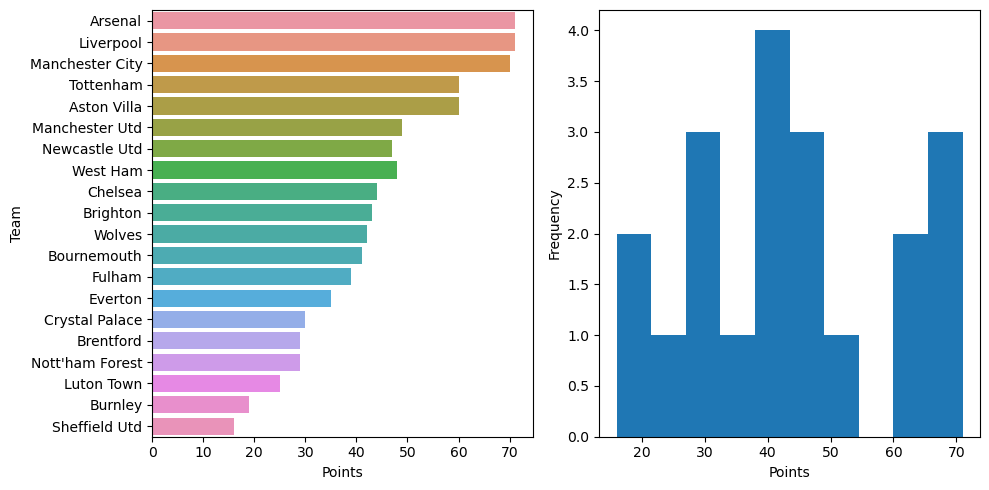

In [3]:
print(f'Mean point total is {df.Points.mean():.3}')
print(f'Median point total is {df.Points.median():.3}')
print(f'Std Dev of point total is {df.Points.std():.3}')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))


sns.barplot(x=df.Points, y=df.Squad, ax=axes[0])
axes[0].set_xlabel("Points")
axes[0].set_ylabel("Team")


axes[1].hist(df.Points)
axes[1].set_xlabel("Points")
axes[1].set_ylabel("Frequency")


plt.tight_layout()
plt.show()

 # Question: Which of the following are statistically significant predictors of Points? Which is the best predictor?
 - Posession
 - Age of Squad
 - Assist %
 - Shots on target
 - XG (expected goals)
 - xAG (expected assists)
 - xGD (expected goals differential)

In [4]:
# REGRESSION FUNCTIONS

def simpleRegPredict(b,x):
    """Prediction function for simple regression
    Args:
        b (array): 2 element array with intercept and slope
        x (array): array of x values
    Returns:
        yp (array): array of predicted y valuess
    """
    yp=b[0]+b[1]*x
    return yp

def simpleRegLossRSS(b,x,y):
    """Simple residual sums of squares loss functions
    Args:
        b (array): 2 element array with intercept and slope
        x (array): array of x values
        y (array): array of y values

    Returns:
        rss (float): Residual sums of squares
        deriv (array): array of derivatives of the loss function with respect to b
    """
    predY = simpleRegPredict(b,x)
    res = y-predY
    rss = sum(res**2)
    deriv = np.zeros(2)
    deriv[0]=-2*sum(res)
    deriv[1]=-2*sum(res*x)
    return (rss,deriv)

def plotPrediction(b,x,y,predfcn):
    """Plot the prediction of a simple regression
    Args:
        b (array): array of parameter values
        x (array): array of x values
        y (array): array of y values
        predfcn (function): prediction function
    """
    fig = plt.figure(figsize=(3, 1.1))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x,y)
    xp = np.linspace(min(x),max(x),num=50)
    yp = predfcn(b,xp)
    ax.plot(xp,yp,'r')

def simpleRegFit(x,y,lossFcn=simpleRegLossRSS):
    """Perform simple regression fit with a loss function
    Args:
        x (array): array of x values
        y (array): array of y values
        lossFcn (function): Loss function Defaults to simpleRegLossRSS.

    Returns:
        R2 (float): Coefficient of determination
        b (array): array of fitted parameter values
    """
    b0=[np.mean(y),0]
    RES = so.minimize(lossFcn,b0,args=(x,y),jac=True)
    b=RES.x # Results
    plotPrediction(b,x,y,simpleRegPredict)
    res = y-np.mean(y)
    TSS = sum(res**2)
    RSS,grad = simpleRegLossRSS(b,x,y)
    R2 = 1-RSS/TSS
    return (R2,b)

R2, Possesion = 0.669
R2, Age = 0.001
R2, Shots on Target = 0.807
R2, Expected goals = 0.791
R2, Expected Assists = 0.807
R2, Expected goal Difference = 0.744
R2, Assist % = 0.037
R2, Aerial Duel % = 0.183
R2, Crosses Per Game = 0.141
R2, Attacking 3rd Tackles = 0.197


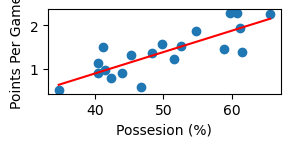

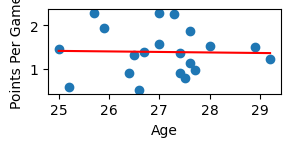

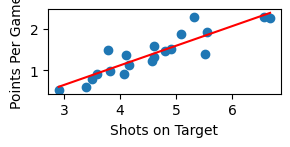

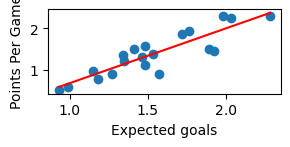

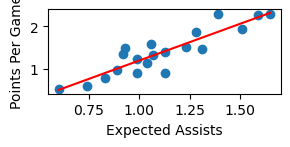

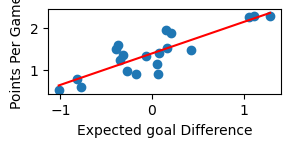

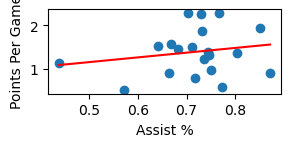

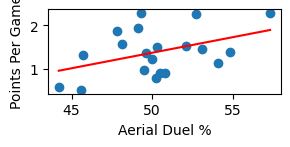

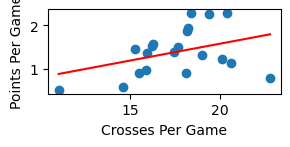

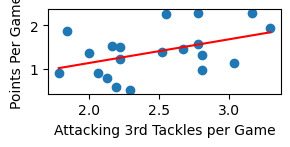

In [5]:
R2,b=simpleRegFit(df.Possesion, df.PPG,lossFcn=simpleRegLossRSS)
plt.ylabel('Points Per Game')
plt.xlabel('Possesion (%)')
print(f'R2, Possesion = {R2:.3f}')

R2,b=simpleRegFit(df.Age, df.PPG,lossFcn=simpleRegLossRSS)
plt.ylabel('Points Per Game')
plt.xlabel('Age')
print(f'R2, Age = {R2:.3f}')

R2,b=simpleRegFit(df.SOT, df.PPG,lossFcn=simpleRegLossRSS)
plt.ylabel('Points Per Game')
plt.xlabel('Shots on Target')
print(f'R2, Shots on Target = {R2:.3f}')

R2,b=simpleRegFit(df.xG_Per_90, df.PPG,lossFcn=simpleRegLossRSS)
plt.ylabel('Points Per Game')
plt.xlabel('Expected goals')
print(f'R2, Expected goals = {R2:.3f}')

R2,b=simpleRegFit(df.xAG_Per_90, df.PPG,lossFcn=simpleRegLossRSS)
plt.ylabel('Points Per Game')
plt.xlabel('Expected Assists')
print(f'R2, Expected Assists = {R2:.3f}')

R2,b=simpleRegFit(df.xGD_Per_90, df.PPG,lossFcn=simpleRegLossRSS)
plt.ylabel('Points Per Game')
plt.xlabel('Expected goal Difference')
print(f'R2, Expected goal Difference = {R2:.3f}')

R2,b=simpleRegFit(df.AstPerc, df.PPG,lossFcn=simpleRegLossRSS)
plt.ylabel('Points Per Game')
plt.xlabel('Assist %')
print(f'R2, Assist % = {R2:.3f}')

R2,b=simpleRegFit(df.Aerial_Duel_Perc, df.PPG,lossFcn=simpleRegLossRSS)
plt.ylabel('Points Per Game')
plt.xlabel('Aerial Duel %')
print(f'R2, Aerial Duel % = {R2:.3f}')

R2,b=simpleRegFit(df.Crs_Per_Game, df.PPG,lossFcn=simpleRegLossRSS)
plt.ylabel('Points Per Game')
plt.xlabel('Crosses Per Game')
print(f'R2, Crosses Per Game = {R2:.3f}')

R2,b=simpleRegFit(df.Att_Tack_Per_Game, df.PPG,lossFcn=simpleRegLossRSS)
plt.ylabel('Points Per Game')
plt.xlabel('Attacking 3rd Tackles per Game')
print(f'R2, Attacking 3rd Tackles = {R2:.3f}')

> Variables vs Points Per Game, with Simple Regression Line.   
Age has almost zero correlation, while Expected Stats and Shots on Goal have very strong correlation. We keep note of this for later, as multicollinearity may be an issue when building model

# Correlation
Now we compute correlation, then will use a permutation test to verify statistical significance, with a p-value benchmark of 0.05 and the following hypotheses:

Null Hypothesis: There is no correlation between the selected variable and Points per Game   
Alternate Hypothesis: There is correlation between the selected variable and Points per Game

In [6]:
def corrcoeff(df, colname): #Column to PPG comparison
    meanx = df[colname].mean()
    meany = df.PPG.mean()
    numerator = np.sum((df[colname] - meanx) * (df.PPG - meany))
    denominator = np.sqrt(np.sum((df[colname] - meanx)**2) * np.sum((df.PPG - meany)**2))
    r = numerator / denominator
    return r

In [7]:
poss_corr = corrcoeff(df, 'Possesion')
print(poss_corr)

0.818148141203586


In [8]:
def randomize_column (df,colname):
    df_copy = df.copy()
    var = df_copy[colname].values
    np.random.shuffle(var)
    df_copy[colname]=var
    return df_copy
def permutation_test(df, numIter, fcn, colname):
    temp_test_stats = np.empty(numIter)
    observed_statistic = fcn(df, colname) #### FUNCTION  
    for i in range(numIter):
        temp_shuffled_df = randomize_column (df, colname)
        temp_test_value = fcn(temp_shuffled_df, colname)
        temp_test_stats[i] = temp_test_value     
    p_value = np.sum(temp_test_stats >= observed_statistic) / numIter
    print(f'P-value: {p_value:.6f}')  
    plt.hist(temp_test_stats)
    plt.title('Permutation Test Statistics')
    plt.xlabel('Difference in Probability, '+colname)
    plt.ylabel('Frequency')
    plt.axvline(observed_statistic, color='red', linestyle='dashed', linewidth=2, label='Empirical Statistic')
    plt.legend()
    plt.show()
    return p_value

P-value: 0.000000


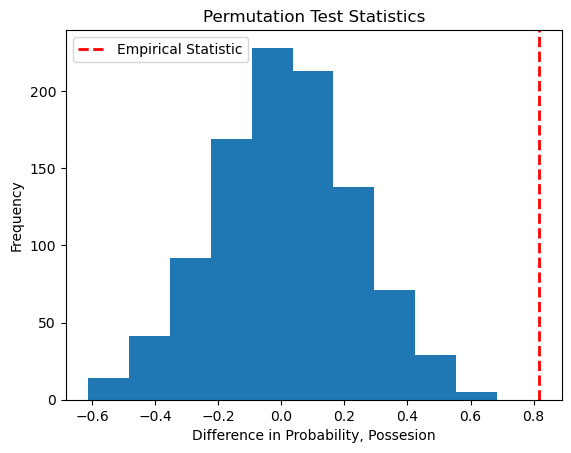

P-value: 0.582000


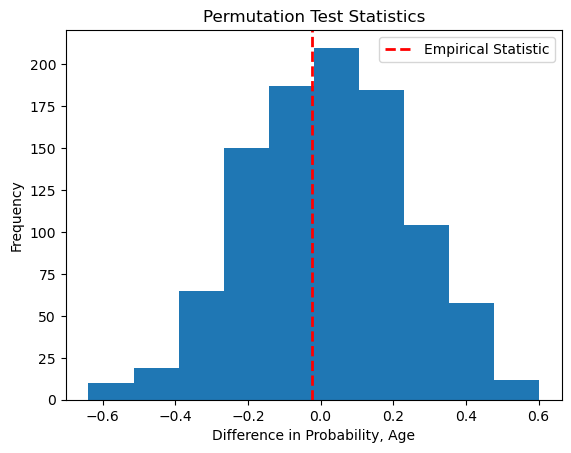

P-value: 0.000000


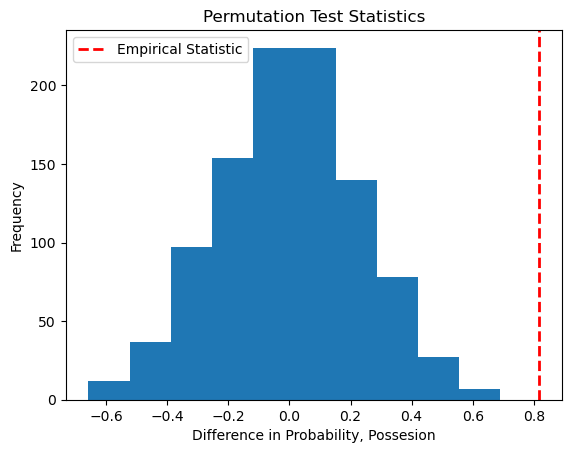

P-value: 0.000000


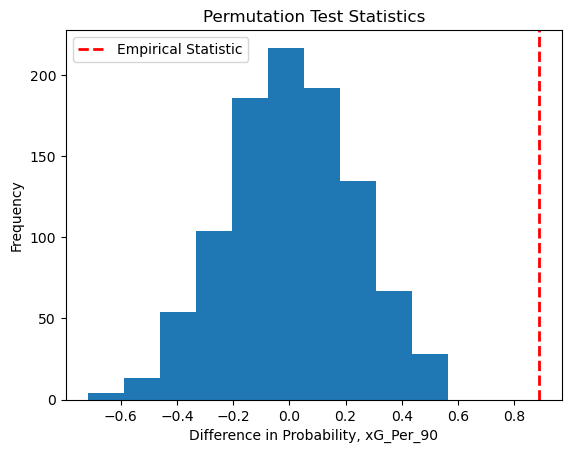

P-value: 0.000000


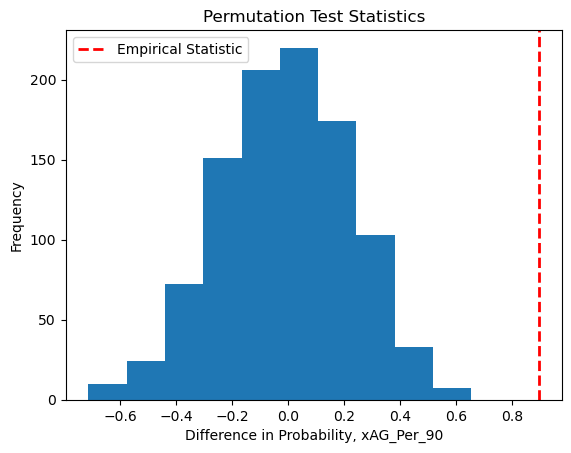

P-value: 0.000000


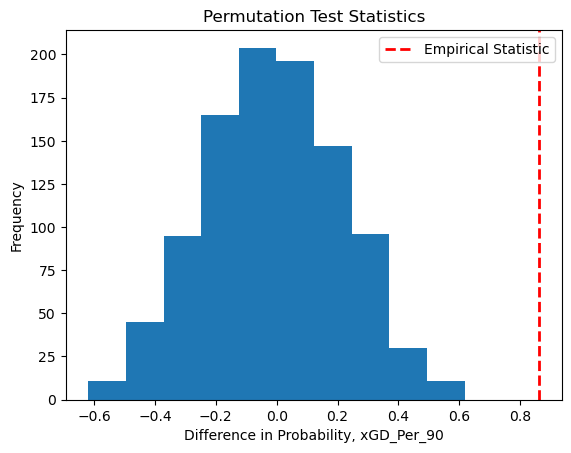

P-value: 0.213000


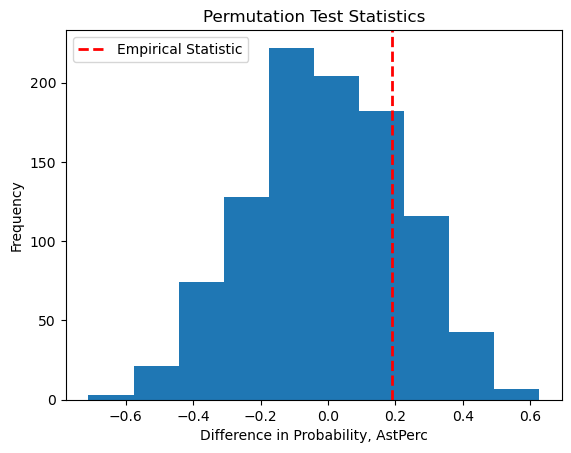

P-value: 0.026000


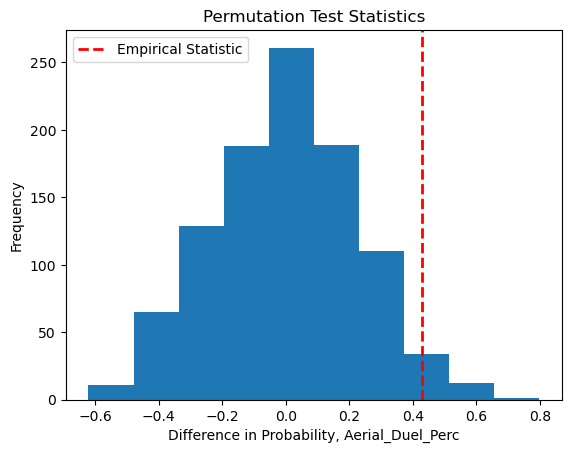

P-value: 0.043000


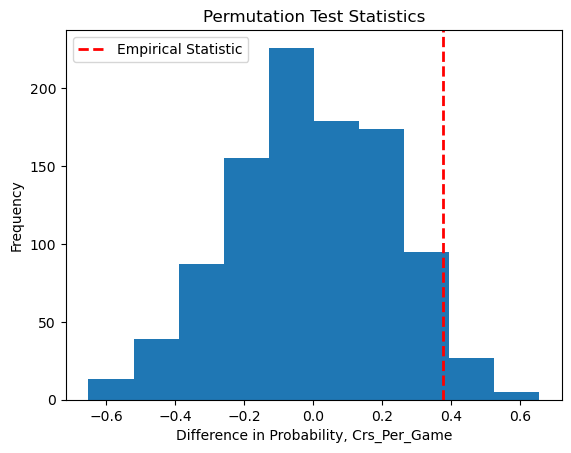

P-value: 0.034000


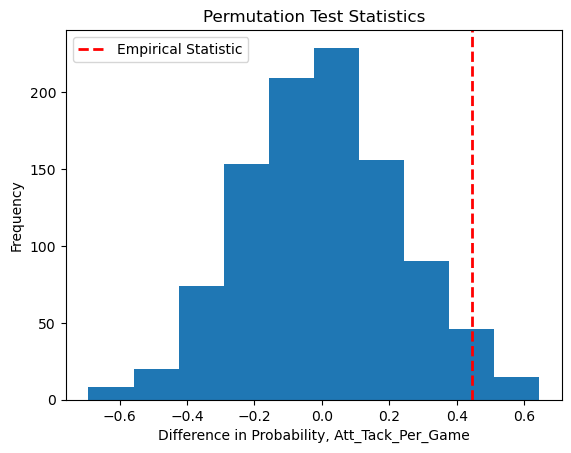

In [9]:
pval_poss = permutation_test(df, 1000, corrcoeff, 'Possesion')
pval_age = permutation_test(df, 1000, corrcoeff, 'Age')
pval_sot = permutation_test(df, 1000, corrcoeff, 'Possesion')
pval_xg = permutation_test(df, 1000, corrcoeff, 'xG_Per_90')
pval_xag = permutation_test(df, 1000, corrcoeff, 'xAG_Per_90')
pval_xgd = permutation_test(df, 1000, corrcoeff, 'xGD_Per_90')
pval_astperc = permutation_test(df, 1000, corrcoeff, 'AstPerc')
pval_aerialduel = permutation_test(df, 1000, corrcoeff, 'Aerial_Duel_Perc')
pval_crosses = permutation_test(df, 1000, corrcoeff, 'Crs_Per_Game')
pval_tackles = permutation_test(df, 1000, corrcoeff, 'Att_Tack_Per_Game')

In [10]:
print(f'P Value, Possesion: {pval_poss:.4f}')
print(f'P Value, Age: {pval_age:.4f}')
print(f'P Value, Shots on target: {pval_sot:.4f}')
print(f'P Value, Expected Goals: {pval_xg:.4f}')
print(f'P Value, Expected Assists: {pval_xag:.4f}')
print(f'P Value, Expected Goal Difference: {pval_xgd:.4f}')
print(f'P Value, Assist Percentage: {pval_astperc:.4f}')
print(f'P Value, Aerial Duel Percentage: {pval_aerialduel:.4f}')
print(f'P Value, Crosses Per Game: {pval_crosses:.4f}')
print(f'P Value, Attacking 3rd Tackles Per Game: {pval_tackles:.4f}')

P Value, Possesion: 0.0000
P Value, Age: 0.5820
P Value, Shots on target: 0.0000
P Value, Expected Goals: 0.0000
P Value, Expected Assists: 0.0000
P Value, Expected Goal Difference: 0.0000
P Value, Assist Percentage: 0.2130
P Value, Aerial Duel Percentage: 0.0260
P Value, Crosses Per Game: 0.0430
P Value, Attacking 3rd Tackles Per Game: 0.0340


> Posession, Shots on target, and all Expcted Metrics have P-values of zero, suggesting the correlation isn't random. Age and Assist% fail to reject the H0 and we thus conclude no correlation, whereas the rest of the stats are near or below the 0.05 threshold. We will explore the best combination of these next, in terms of predictability power.

# Multiple Regression
Next, we will perform multiple regression on the relevant regressors, and attempt to build the most accurate model from the data we have. We'll test on the following:   
   
- Aerial Duel %   
- Crosses Per Game   
- Attacking 3rd tackles Per game

In [11]:
def multRegPredict(b,D,xname):
    yp=np.ones(len(D.index))*b[0]        # Intercept
    for i in range(len(xname)):
        yp=yp+D[xname[i]]*b[i+1]         # Add each regression value
    return yp

def multRegLossRSS(b,D,y,xname):
    predY = multRegPredict(b,D,xname)
    res = y-predY
    rss = sum(res**2)
    grad=np.zeros(len(b))
    grad[0]=-2*np.sum(res)
    for i in range(len(xname)):
        grad[i+1]=-2*np.sum(D[xname[i]]*res)
    return (rss,grad)

def multRegFit(D,y,xname):
    N=len(xname)
    b0=np.zeros((N+1,))
    RES = so.minimize(multRegLossRSS,b0,args=(D,y,xname),jac=True)
    b=RES.x # Results
    res = y-np.mean(y)
    TSS = sum(res**2)
    RSS,deriv = multRegLossRSS(b,D,y,xname)
    R2 = 1-RSS/TSS
    return (R2,b)

In [12]:
R1, B1 = multRegFit(df, df.PPG, ['Aerial_Duel_Perc'])
print(f"Aerial_Duel_Perc R2 is {R1:3.3f}")

R2, B2 = multRegFit(df, df.PPG, ['Crs_Per_Game'])
print(f"Crs_Per_Game R2 is {R2:3.3f}")

R3, B3 = multRegFit(df, df.PPG, ['Att_Tack_Per_Game'])
print(f"Att_Tack_Per_Game R2 is {R3:3.3f}")

# Fourth iteration: Two predictors 'Aerial_Duel_Perc' + 'Crs_Per_Game'
R4, B4 = multRegFit(df, df.PPG, ['Aerial_Duel_Perc', 'Crs_Per_Game'])
print(f"Aerial_Duel_Perc + Crs_Per_Game R2 is {R4:3.3f}")

R5, B5 = multRegFit(df, df.PPG, ['Aerial_Duel_Perc', 'Att_Tack_Per_Game'])
print(f"Aerial_Duel_Perc + Att_Tack_Per_Game R2 is {R5:3.3f}")

R6, B6 = multRegFit(df, df.PPG, ['Crs_Per_Game', 'Att_Tack_Per_Game'])
print(f"Crs_Per_Game + Att_Tack_Per_Game R2 is {R6:3.3f}")

R7, B7 = multRegFit(df, df.PPG, ['Aerial_Duel_Perc', 'Crs_Per_Game', 'Att_Tack_Per_Game'])
print(f"Aerial_Duel_Perc + Crs_Per_Game + Att_Tack_Per_Game R2 is {R7:3.3f}")

Aerial_Duel_Perc R2 is 0.183
Crs_Per_Game R2 is 0.141
Att_Tack_Per_Game R2 is 0.197
Aerial_Duel_Perc + Crs_Per_Game R2 is 0.228
Aerial_Duel_Perc + Att_Tack_Per_Game R2 is 0.295
Crs_Per_Game + Att_Tack_Per_Game R2 is 0.274
Aerial_Duel_Perc + Crs_Per_Game + Att_Tack_Per_Game R2 is 0.323


## None of these are great. Let's add in possesion

In [13]:
R1, B1 = multRegFit(df, df.PPG, ['Possesion'])
print(f"Possesion R2 is {R1:3.3f}")

R2, B2 = multRegFit(df, df.PPG, ['Aerial_Duel_Perc', 'Possesion'])
print(f"Aerial_Duel_Perc + Possesion R2 is {R2:3.3f}")

R3, B3 = multRegFit(df, df.PPG, ['Crs_Per_Game', 'Possesion'])
print(f"Crs_Per_Game + Possesion R2 is {R3:3.3f}")

R4, B4 = multRegFit(df, df.PPG, ['Att_Tack_Per_Game', 'Possesion'])
print(f"Att_Tack_Per_Game + Possesion R2 is {R4:3.3f}")

R5, B5 = multRegFit(df, df.PPG, ['Aerial_Duel_Perc', 'Crs_Per_Game', 'Possesion'])
print(f"Aerial_Duel_Perc + Crs_Per_Game + Possesion R2 is {R5:3.3f}")

R6, B6 = multRegFit(df, df.PPG, ['Aerial_Duel_Perc', 'Att_Tack_Per_Game', 'Possesion'])
print(f"Aerial_Duel_Perc + Att_Tack_Per_Game + Possesion R2 is {R6:3.3f}")

R7, B7 = multRegFit(df, df.PPG, ['Crs_Per_Game', 'Att_Tack_Per_Game', 'Possesion'])
print(f"Crs_Per_Game + Att_Tack_Per_Game + Possesion R2 is {R7:3.3f}")

R8, B8 = multRegFit(df, df.PPG, ['Aerial_Duel_Perc', 'Crs_Per_Game', 'Att_Tack_Per_Game', 'Possesion'])
print(f"Aerial_Duel_Perc + Crs_Per_Game + Att_Tack_Per_Game + Possesion R2 is {R8:3.3f}")

Possesion R2 is 0.669
Aerial_Duel_Perc + Possesion R2 is 0.675
Crs_Per_Game + Possesion R2 is 0.694
Att_Tack_Per_Game + Possesion R2 is 0.693
Aerial_Duel_Perc + Crs_Per_Game + Possesion R2 is 0.694
Aerial_Duel_Perc + Att_Tack_Per_Game + Possesion R2 is 0.696
Crs_Per_Game + Att_Tack_Per_Game + Possesion R2 is 0.711
Aerial_Duel_Perc + Crs_Per_Game + Att_Tack_Per_Game + Possesion R2 is 0.711


# The last 2 have equal R2 values. Lets find the crossvalidated R2's to select the better model 

In [14]:
def leaveOneOutCV(D,y,xname,fitfcn=multRegFit,predictfcn=multRegPredict):
    N = len(y) #Number of observations
    yp= np.zeros(N)
    ind = np.arange(N)
    for i in range(N):
        R2,b=fitfcn(D[ind!=i],y[ind!=i],xname)
        yp[i]=predictfcn(b,D[ind==i],xname)
    TSS  = sum((y-y.mean())**2)
    RSS = sum((y-yp)**2)
    R2cv = 1-RSS/TSS
    return R2cv

In [15]:
pR2_1 = leaveOneOutCV(df,df.PPG,['Crs_Per_Game', 'Att_Tack_Per_Game', 'Possesion'])
print(f'Predictive R2 for Crs_Per_Game + Att_Tack_Per_Game + Possesion is {pR2_1:3.3f}')

pR2_2 = leaveOneOutCV(df,df.PPG,['Aerial_Duel_Perc', 'Crs_Per_Game', 'Att_Tack_Per_Game', 'Possesion'])
print(f'Predictive R2 for Aerial_Duel_Perc + Crs_Per_Game + Att_Tack_Per_Game + Possesion is {pR2_2:3.3f}')

C:\Users\dakae\AppData\Local\Temp\ipykernel_20860\1666679671.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  yp[i]=predictfcn(b,D[ind==i],xname)


Predictive R2 for Crs_Per_Game + Att_Tack_Per_Game + Possesion is 0.563
Predictive R2 for Aerial_Duel_Perc + Crs_Per_Game + Att_Tack_Per_Game + Possesion is 0.496


# Attacking tackles Per Game, Crosses Per game, and Possesion seem to makeup the best model out of all the regressors tested


# Now for the grand finale. Lets use this model to predict the table for the previous season, and compare it to the real results

In [16]:
R9 = R7
B9 = B7

In [17]:
df6=pd.read_csv("C:/Users/dakae/Downloads/archive (1)/2022_23 EPL Data.csv")

df6.rename(columns={'# Pl': 'Total_MP'}, inplace=True)
df6.rename(columns={'Poss': 'Possesion'}, inplace=True)
df6.rename(columns={'Crs': 'Crs_Per_Game'}, inplace=True)
df6.rename(columns={'Att 3rd': 'Att_Tack_Per_Game'}, inplace=True)

df6['PPG'] = df6.Points/38

display(df6.columns)

Index(['Squad', 'Total_MP', 'Possesion', 'Crs_Per_Game', 'Won%', 'Points',
       'xG_Per_90', 'xGA_per_90', 'xGD_Per_90', 'Att_Tack_Per_Game', 'PPG'],
      dtype='object')

In [18]:
def predict_points(df, regressors, B):
    # Extract the relevant columns from the new dataset
    X_new = df[regressors]

    # Use the correct coefficient array (replace `B9` with your coefficient array)
    predicted_ppg = multRegPredict(B, X_new, regressors)

    # Add predictions to the new dataset
    df['Predicted_Points'] = predicted_ppg * 38  # Multiply by total matches to get points
    df['Residual'] = df['Points'] - df['Predicted_Points']

    # Display the dataset with predicted points and residuals
    #print(df[['Squad', 'Predicted_Points', 'Points', 'Residual']])
    return df

regressors = ['Crs_Per_Game', 'Att_Tack_Per_Game', 'Possesion']
predict_points(df6, regressors, B9)

,Squad,Total_MP,Possesion,Crs_Per_Game,Won%,Points,xG_Per_90,xGA_per_90,xGD_Per_90,Att_Tack_Per_Game,PPG,Predicted_Points,Residual
0,Arsenal,38,59.3,17.7,46.5,84,1.89,1.10,0.79,3.11,2.210526,72.663608,11.336392
1,Aston Villa,38,49.3,14.8,48.7,61,1.32,1.38,-0.06,2.03,1.605263,45.658969,15.341031
2,Bournemouth,38,40.4,13.4,49.2,39,1.02,1.68,-0.66,1.39,1.026316,25.061052,13.938948
3,Brentford,38,43.8,17.4,51.8,59,1.49,1.31,0.18,2.34,1.552632,41.435291,17.564709
4,Brighton,38,60.2,18.3,53.4,62,1.93,1.32,0.61,2.74,1.631579,72.357424,-10.357424
5,Chelsea,38,58.7,18.2,52.1,44,1.30,1.38,-0.08,2.89,1.157895,70.751513,-26.751513
6,Crystal Palace,38,46.3,15.6,46.2,45,1.03,1.26,-0.23,2.37,1.184211,43.812883,1.187117
7,Everton,38,42.8,18.5,48.7,36,1.19,1.73,-0.54,2.34,0.947368,40.981938,-4.981938
8,Fulham,38,48.8,20.2,48.2,52,1.22,1.68,-0.46,2.66,1.368421,54.957813,-2.957813
9,Leeds United,38,47.0,17.2,49.1,31,1.25,1.77,-0.52,3.18,0.815789,52.126874,-21.126874


In [30]:
def analyze_model(df):
    #============== DESCRIPIVE STATS ==============
    # Mean Squared Error (MSE)
    mse = np.mean(df['Residual'] ** 2)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # R-Squared (R^2)
    ss_total = np.sum((df['Points'] - df['Points'].mean()) ** 2)
    ss_residual = np.sum(df['Residual'] ** 2)
    r2 = 1 - (ss_residual / ss_total)

    # Standard deviation of residuals
    std_dev_residuals = np.std(df['Residual'])

    print(f"MSE: {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R^2: {r2:.3f}")
    print(f"Std Dev of Residuals: {std_dev_residuals:.3f}")
    
    #============== PREDICTED VS ACTUAL, BAR CHART=================
    df_sorted = df.sort_values(by='Points')

    x = np.arange(len(df_sorted))  # Positions for the teams
    bar_width = 0.3  # Width of the bars

    # Plot the actual and predicted points as bar charts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    bars1 = ax1.bar(x - bar_width / 2, df_sorted['Points'], bar_width, label='Actual Points')
    bars2 = ax1.bar(x + bar_width / 2, df_sorted['Predicted_Points'], bar_width, label='Predicted Points', alpha=0.7)

    # Add labels, title, and legend
    ax1.set_xlabel('Squad')
    ax1.set_ylabel('Points')
    ax1.set_title('Comparison of Actual vs Predicted Points per Team')
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_sorted['Squad'], rotation=45, ha='right')
    ax1.legend()
    
    
    #============== RESIDUALS BAR CHART =============
    df_temp = df.sort_values(by='Residual')
    sns.barplot(y=df_temp.Squad, x=df_temp.Residual)
    ax2.set_xlabel('Residual')
    ax2.set_ylabel('Squad')
    ax2.set_title('Residuals by Squad')
    
    plt.tight_layout()
    plt.show() 

MSE: 175.680
RMSE: 13.254
R^2: 0.441
Std Dev of Residuals: 13.198


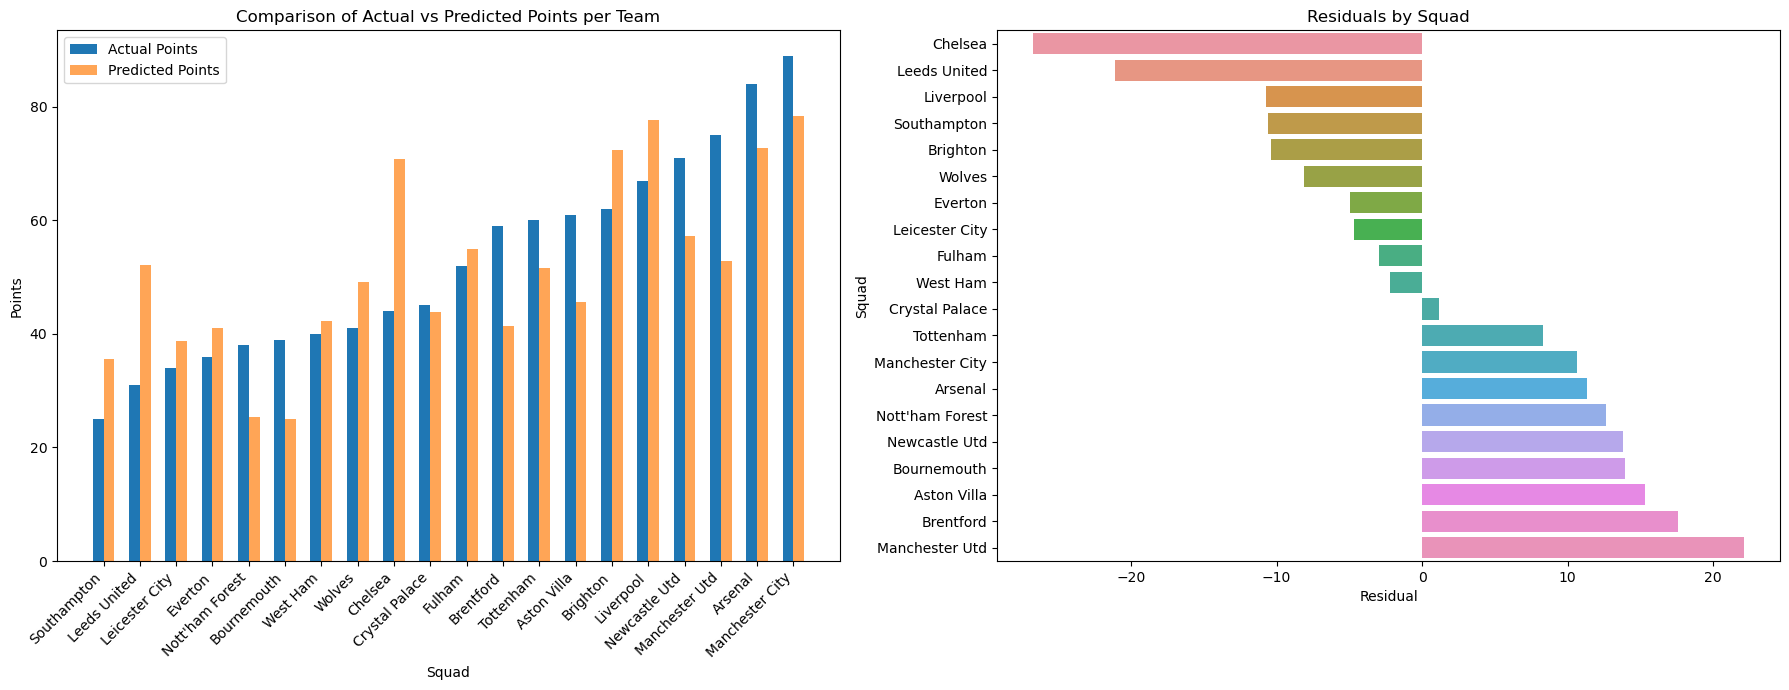

In [31]:
analyze_model(df6)   

> The R2 value is just 0.441, suggesting over 50% of variance is unexplained by this model. The Std Dev of 13.204 points, and RMSE of 13.261 points suggest relatively high levels of variability in prediction accuracy 

# CONCLUSIONS
- Overall, our model derived from Possesion, Attacking Tackles Per 3rd, and Crosses Per game has poor to moderate predictive power. Large underpredictions (Chelsea) and overpredictions (Manchester Utd) exist, pointing to the incompleteness of the model

# Next Steps and Improvements
- Of course, there are hundreds of possible regressors we should test and we only tested a handful of them. A much more rigourous analysis of a wider set of regressors would yield a better result
- We performed analysis on an already aggregated set of data (seasonal). Performing game-to-game analysis rather than seasonal analysis would likely yield better results, due to the increased granularity of the data
- Even within our chosen model, we could perform regularization (eg Ridge or Lasso Regression) to deal with overfitting and overallocation to certain variables
# Experiment
- Despite my suspicions of multicollinearity, lets add Expected Goal Difference to the model, then compare that to a model with only Expected Goal Difference, and see if our chosen regressors can improve on that model

In [32]:
R10, B10 = multRegFit(df, df.PPG, ['Crs_Per_Game', 'Att_Tack_Per_Game', 'Possesion', 'xGD_Per_90'])
df7 = df6.drop(columns=['Predicted_Points', 'Residual'])

In [33]:
# Define the desired regressors
regressors = ['Crs_Per_Game', 'Att_Tack_Per_Game', 'Possesion', 'xGD_Per_90']

predict_points(df7, regressors, B10)

,Squad,Total_MP,Possesion,Crs_Per_Game,Won%,Points,xG_Per_90,xGA_per_90,xGD_Per_90,Att_Tack_Per_Game,PPG,Predicted_Points,Residual
0,Arsenal,38,59.3,17.7,46.5,84,1.89,1.10,0.79,3.11,2.210526,76.405936,7.594064
1,Aston Villa,38,49.3,14.8,48.7,61,1.32,1.38,-0.06,2.03,1.605263,48.229537,12.770463
2,Bournemouth,38,40.4,13.4,49.2,39,1.02,1.68,-0.66,1.39,1.026316,27.487828,11.512172
3,Brentford,38,43.8,17.4,51.8,59,1.49,1.31,0.18,2.34,1.552632,50.051840,8.948160
4,Brighton,38,60.2,18.3,53.4,62,1.93,1.32,0.61,2.74,1.631579,73.278325,-11.278325
5,Chelsea,38,58.7,18.2,52.1,44,1.30,1.38,-0.08,2.89,1.157895,60.413172,-16.413172
6,Crystal Palace,38,46.3,15.6,46.2,45,1.03,1.26,-0.23,2.37,1.184211,44.171058,0.828942
7,Everton,38,42.8,18.5,48.7,36,1.19,1.73,-0.54,2.34,0.947368,37.312094,-1.312094
8,Fulham,38,48.8,20.2,48.2,52,1.22,1.68,-0.46,2.66,1.368421,45.750649,6.249351
9,Leeds United,38,47.0,17.2,49.1,31,1.25,1.77,-0.52,3.18,0.815789,43.057743,-12.057743


MSE: 78.158
RMSE: 8.841
R^2: 0.751
Std Dev of Residuals: 8.821


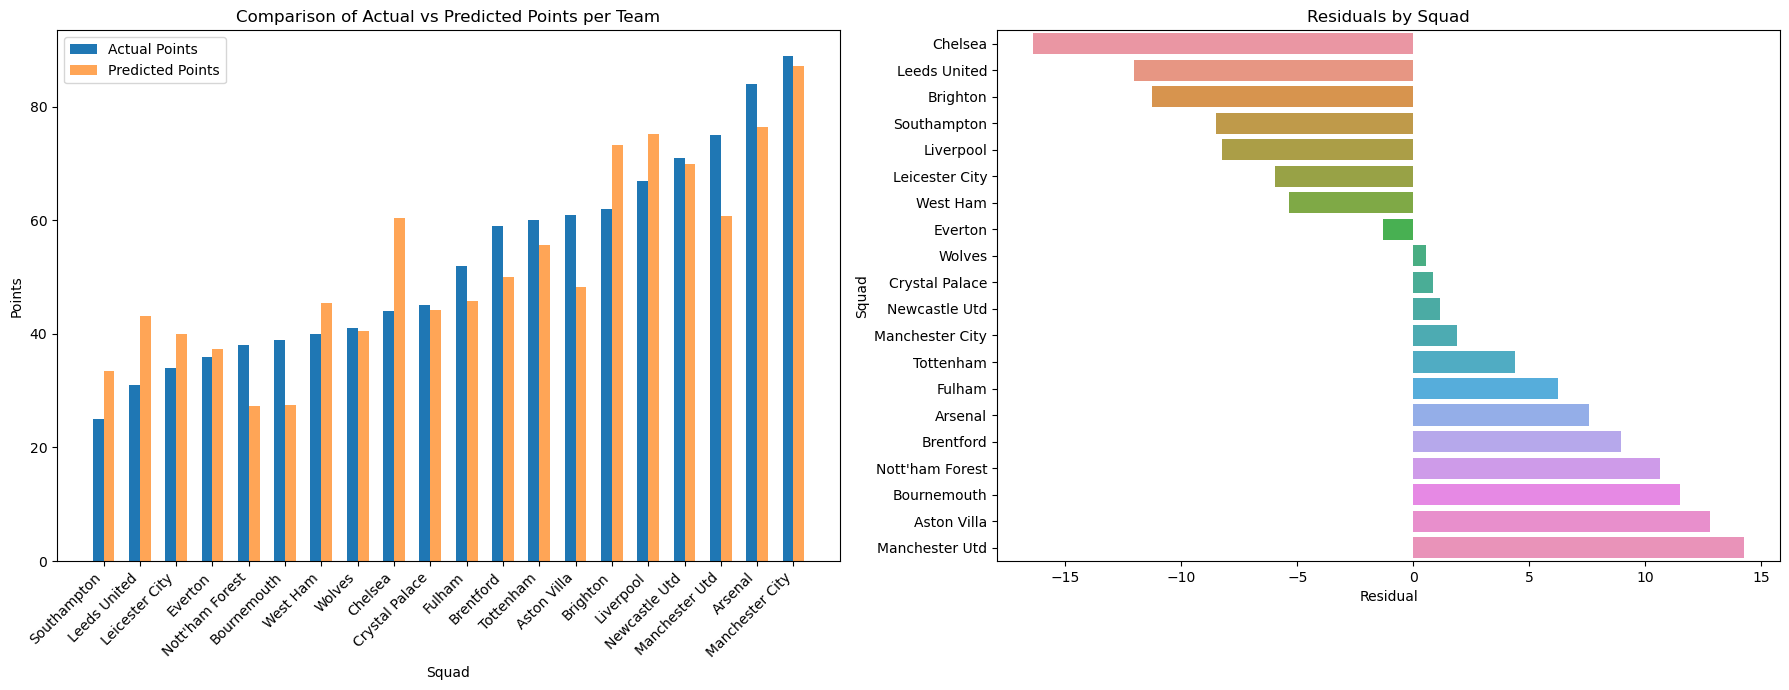

In [34]:
analyze_model(df7)  

> This model has better predicive power. 75% of variability is explained, and the Std Dev is cut to 8.82 points. Lets see if it performs better than a model build purely on posession

In [35]:
df8 = df7.drop(columns=['Predicted_Points', 'Residual'])
df8.columns

Index(['Squad', 'Total_MP', 'Possesion', 'Crs_Per_Game', 'Won%', 'Points',
       'xG_Per_90', 'xGA_per_90', 'xGD_Per_90', 'Att_Tack_Per_Game', 'PPG'],
      dtype='object')

In [36]:
R11, B11 = multRegFit(df, df.PPG, ['xGD_Per_90'])

In [37]:
# Define the desired regressors
regressors = ['xGD_Per_90']

predict_points(df8, regressors, B11)

,Squad,Total_MP,Possesion,Crs_Per_Game,Won%,Points,xG_Per_90,xGA_per_90,xGD_Per_90,Att_Tack_Per_Game,PPG,Predicted_Points,Residual
0,Arsenal,38,59.3,17.7,46.5,84,1.89,1.10,0.79,3.11,2.210526,75.272956,8.727044
1,Aston Villa,38,49.3,14.8,48.7,61,1.32,1.38,-0.06,2.03,1.605263,50.980935,10.019065
2,Bournemouth,38,40.4,13.4,49.2,39,1.02,1.68,-0.66,1.39,1.026316,33.833626,5.166374
3,Brentford,38,43.8,17.4,51.8,59,1.49,1.31,0.18,2.34,1.552632,57.839858,1.160142
4,Brighton,38,60.2,18.3,53.4,62,1.93,1.32,0.61,2.74,1.631579,70.128763,-8.128763
5,Chelsea,38,58.7,18.2,52.1,44,1.30,1.38,-0.08,2.89,1.157895,50.409358,-6.409358
6,Crystal Palace,38,46.3,15.6,46.2,45,1.03,1.26,-0.23,2.37,1.184211,46.122531,-1.122531
7,Everton,38,42.8,18.5,48.7,36,1.19,1.73,-0.54,2.34,0.947368,37.263088,-1.263088
8,Fulham,38,48.8,20.2,48.2,52,1.22,1.68,-0.46,2.66,1.368421,39.549395,12.450605
9,Leeds United,38,47.0,17.2,49.1,31,1.25,1.77,-0.52,3.18,0.815789,37.834665,-6.834665


MSE: 48.628
RMSE: 6.973
R^2: 0.845
Std Dev of Residuals: 6.973


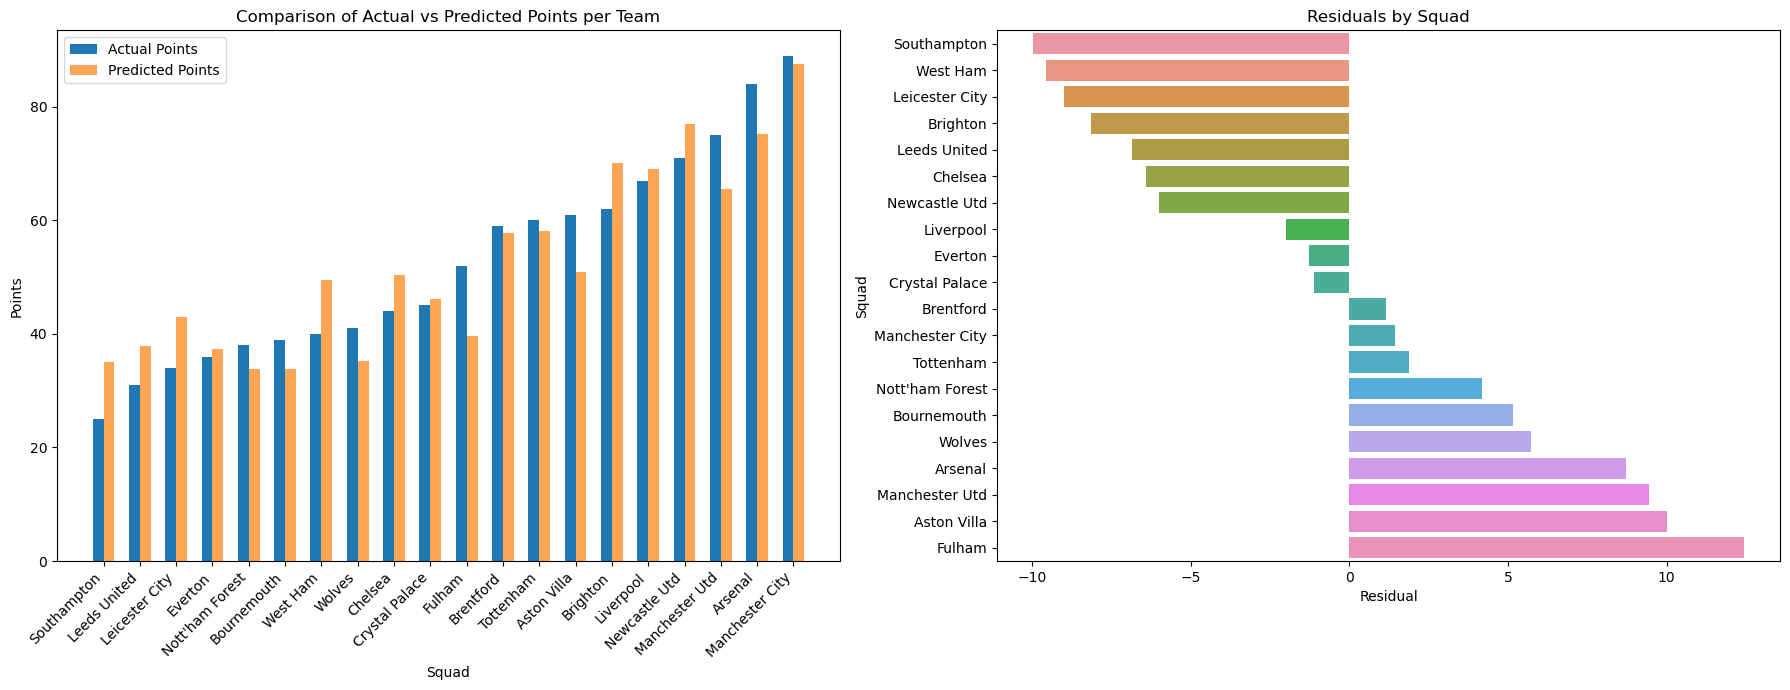

In [38]:
analyze_model(df8)

> It appears our model performs better if we drop everything besides Goal Difference! Isn't that funny. This goes to show that more isn't always better. it appears many of the regressors we tested for were just noise, and a simple model based on purely goal difference actually outperforms. A rigorous analysis testing with more regressors may improve on this model, but based on the lmiited scope of this analysis, it appears less is more!